In [1]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
import json
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

# Configuration
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

In [2]:
# Import de la classe WindowedDataset
from src.data.windowed_dataset import WindowedDataset

dataset = WindowedDataset(
    dir="/home/nadir/disk/datasets/babel-for-validation",
    for_validation=True,
    window_size=20,
    normalize=False,
    balanced=False,
    preload=False
)

[slef.dir]: /home/nadir/disk/datasets/babel-for-validation/20-1
here


In [3]:
# Configuration du modèle à analyser
run_dir = "/home/nadir/tmr-code/outputs/archives.new/start-end-segmentation_tmr_majority-based-start-end-with-majority_False_mlp_20"
device = "cuda:1"
ckpt_name = "best"

print(f"Analyse du modèle: {os.path.basename(run_dir)}")

Analyse du modèle: start-end-segmentation_tmr_majority-based-start-end-with-majority_False_mlp_20


In [4]:
# Import des modules spécifiques
import sys
sys.path.append('/home/nadir/tmr-code')

from src.config import read_config
from src.load import load_model_from_cfg
from hydra.utils import instantiate
import pytorch_lightning as pl

# Chargement de la configuration et du modèle
cfg = read_config(run_dir)
pl.seed_everything(cfg.seed)

print("Configuration chargée:") 
print(f"- Window size: {cfg.data.window_size}")
print(f"- Model type: {cfg.model._target_}")
print(f"- Encoder: {cfg.model.motion_encoder._target_}")
print(f"- Label extractor: {cfg.model.label_extractor._target_}")

# Charger le modèle
model = load_model_from_cfg(cfg, ckpt_name, eval_mode=True, device=device)
model = model.eval()

print("Modèle chargé avec succès!")

Global seed set to 1234


Configuration chargée:
- Window size: 20
- Model type: src.model.StartEndSegmentationModel
- Encoder: src.model.encoders.tmr.TMR
- Label extractor: src.model.label_extractors.transition_or_action_based_start_end_with_majority.MajorityBasedStartEndWithMajority
Modèle chargé avec succès!


In [5]:
# Configuration du dataset pour l'analyse
window_size = cfg.data.window_size

# Dataset pour l'analyse complète
analysis_dataset = instantiate(cfg.data, window_size=window_size, split="all", for_validation=True)

# Charger les statistiques de normalisation
normalization_stats = torch.load(os.path.join(analysis_dataset.dir, "motion_normalization_stats.pt"))
mean = normalization_stats["mean"]
std = normalization_stats["std"]

print(f"Dataset configuré:")
print(f"- Taille: {len(analysis_dataset)}")
print(f"- Window size: {window_size}")
print(f"- Features shape: {mean.shape}")

[slef.dir]: /home/nadir/windowed-babel/20-1
here
Dataset configuré:
- Taille: 172580
- Window size: 20
- Features shape: torch.Size([22, 3])


In [6]:
def get_model_predictions(model, dataset, device, batch_size=32):
    """Extraire toutes les prédictions du modèle avec les scores de confiance"""
    all_preds = []
    all_labels = []
    all_scores = []
    all_sequence_lengths = []
    all_motion_data = []
    
    model.eval()
    
    with torch.no_grad():
        for i in tqdm(range(0, len(dataset), batch_size), desc="Extraction des prédictions"):
            batch_indices = range(i, min(i + batch_size, len(dataset)))
            
            batch_motion = []
            batch_labels = []
            
            for idx in batch_indices:
                sample = dataset[idx]
                # print(sample.keys())
                sample["transition_mask"] = sample["annotation"]
                motion = sample["transformed_motion"]
                label = sample["transition_mask"]
                
                batch_motion.append(motion)
                batch_labels.append(label)
                all_sequence_lengths.append(len(motion))
                all_motion_data.append(motion.cpu().numpy())
            
            # Stack le batch
            batch_motion = torch.stack(batch_motion).to(device)
            batch_labels = torch.stack(batch_labels)
            
            # Prédictions du modèle
            batch_dict = {
                "motion": batch_motion,
                "annotation": batch_labels,
                "transition_mask": batch_labels,
                "transformed_motion": batch_motion
            }
            class_logits, start_logits, end_logits = model(batch_dict, None)
            
            logits = class_logits
            
            # Convertir en probabilités
            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).long()
            
            # Stocker les résultats
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch_labels.numpy())
            all_scores.extend(probs.cpu().numpy())
    
    return {
        'predictions': all_preds,
        'labels': all_labels, 
        'scores': all_scores,
        'sequence_lengths': all_sequence_lengths,
        'motion_data': all_motion_data
    }

print("Fonction d'extraction des prédictions définie")

Fonction d'extraction des prédictions définie


In [7]:
# Extraire toutes les prédictions
print("Extraction des prédictions du modèle...")
results = get_model_predictions(model, analysis_dataset, device)

predictions = results['predictions']
labels = results['labels']
scores = results['scores']
sequence_lengths = results['sequence_lengths']
motion_data = results['motion_data']

print(f"Prédictions extraites pour {len(predictions)} séquences")
print(f"Longueurs de séquences: min={min(sequence_lengths)}, max={max(sequence_lengths)}, mean={np.mean(sequence_lengths):.1f}")

Extraction des prédictions du modèle...


Extraction des prédictions: 100%|██████████| 5394/5394 [02:51<00:00, 31.45it/s]

Prédictions extraites pour 172580 séquences
Longueurs de séquences: min=20, max=20, mean=20.0


In [8]:
def analyze_transition_lengths(predictions, labels, scores):
    """Analyser les erreurs en fonction de la longueur des transitions"""
    transition_analysis = []
    
    for seq_idx, (pred_seq, label_seq, score_seq) in enumerate(zip(predictions, labels, scores)):
        # Trouver les segments de transition dans les labels (ground truth)
        gt_segments = extract_segments(label_seq)
        pred_segments = extract_segments(pred_seq)
        
        for label, start, end in gt_segments:
            if label == 1:  # Transition
                length = end - start
                
                # Vérifier si cette transition a été correctement prédite
                pred_values = pred_seq[start:end]
                correct_ratio = np.mean(pred_values == 1)
                avg_confidence = np.mean(score_seq[start:end])
                
                transition_analysis.append({
                    'sequence_idx': seq_idx,
                    'transition_length': length,
                    'start_pos': start,
                    'end_pos': end,
                    'correct_ratio': correct_ratio,
                    'avg_confidence': avg_confidence,
                    'fully_correct': correct_ratio == 1.0,
                    'partially_correct': 0.5 <= correct_ratio < 1.0,
                    'mostly_wrong': correct_ratio < 0.5
                })
    
    return pd.DataFrame(transition_analysis)

def extract_segments(sequence):
    """Extraire les segments d'une séquence de labels"""
    if len(sequence) == 0:
        return []
    
    segments = []
    current_label = sequence[0]
    start_idx = 0
    
    for i in range(1, len(sequence)):
        if sequence[i] != current_label:
            segments.append((current_label, start_idx, i))
            current_label = sequence[i]
            start_idx = i
    
    segments.append((current_label, start_idx, len(sequence)))
    return segments

# Analyser les transitions
transition_df = analyze_transition_lengths(predictions, labels, scores)
print(f"Nombre de transitions analysées: {len(transition_df)}")
print("\nStatistiques par longueur de transition:")
print(transition_df.groupby('transition_length').agg({
    'correct_ratio': ['mean', 'std', 'count'],
    'avg_confidence': ['mean', 'std']
}).round(3))

Nombre de transitions analysées: 89513

Statistiques par longueur de transition:
                  correct_ratio              avg_confidence       
                           mean    std count           mean    std
transition_length                                                 
1                         0.037  0.189  2495          0.038  0.182
2                         0.037  0.190  2509          0.039  0.183
3                         0.040  0.196  2458          0.041  0.189
4                         0.043  0.203  2353          0.045  0.196
5                         0.044  0.204  2203          0.047  0.200
6                         0.048  0.213  2069          0.052  0.208
7                         0.052  0.223  1925          0.059  0.214
8                         0.077  0.266  1782          0.098  0.241
9                         0.267  0.443  1634          0.293  0.327
10                        0.852  0.355  1498          0.763  0.251
11                        0.976  0.153  1382    

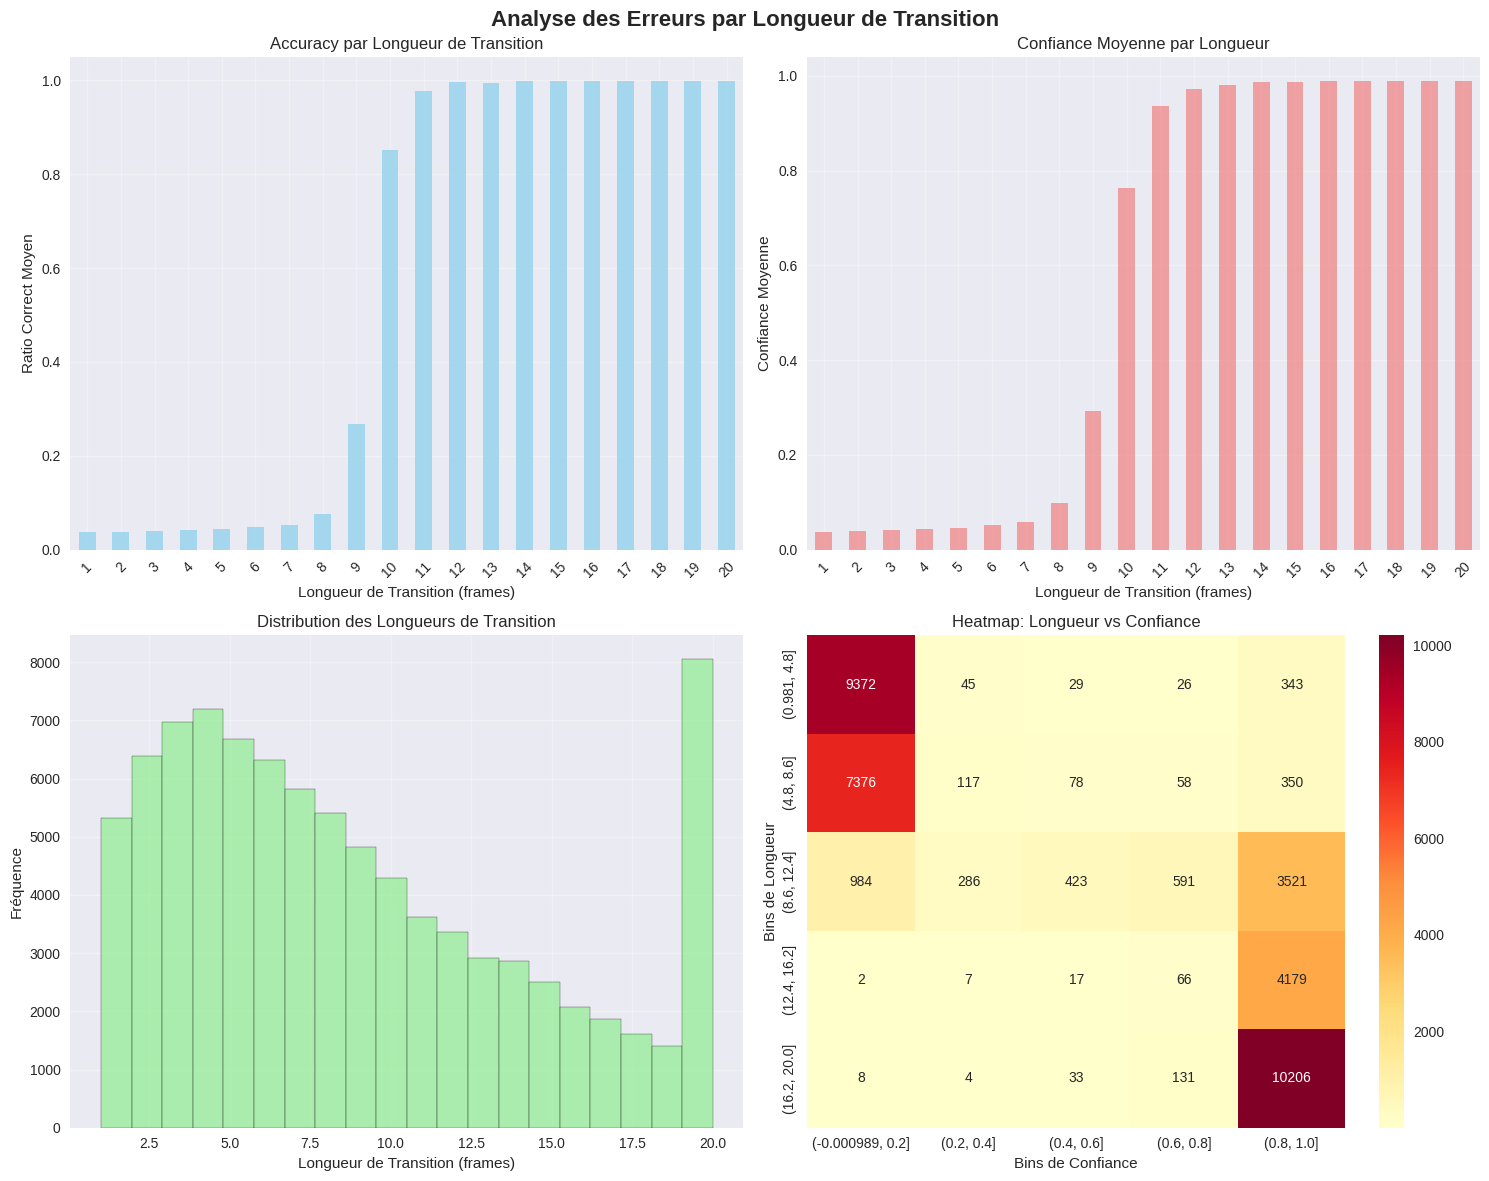


=== ANALYSE DÉTAILLÉE DES TRANSITIONS ===
Transitions très courtes (1-2 frames): 11717
Transitions courtes (3-5 frames): 20843
Transitions moyennes (6-10 frames): 26665
Transitions longues (>10 frames): 30288

Accuracy par catégorie:
  Très courtes (1-2): 0.037 ± 0.190 (n=11717)
  Courtes (3-5): 0.042 ± 0.201 (n=20843)
  Moyennes (6-10): 0.230 ± 0.421 (n=26665)
  Longues (>10): 0.996 ± 0.063 (n=30288)


In [9]:
# Visualisation des erreurs par longueur de transition
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Analyse des Erreurs par Longueur de Transition', fontsize=16, fontweight='bold')

# 1. Accuracy vs longueur de transition
ax1 = axes[0, 0]
length_accuracy = transition_df.groupby('transition_length')['correct_ratio'].mean()
length_accuracy.plot(kind='bar', ax=ax1, color='skyblue', alpha=0.7)
ax1.set_title('Accuracy par Longueur de Transition')
ax1.set_xlabel('Longueur de Transition (frames)')
ax1.set_ylabel('Ratio Correct Moyen')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, alpha=0.3)

# 2. Confiance vs longueur de transition
ax2 = axes[0, 1]
length_confidence = transition_df.groupby('transition_length')['avg_confidence'].mean()
length_confidence.plot(kind='bar', ax=ax2, color='lightcoral', alpha=0.7)
ax2.set_title('Confiance Moyenne par Longueur')
ax2.set_xlabel('Longueur de Transition (frames)')
ax2.set_ylabel('Confiance Moyenne')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3)

# 3. Distribution des longueurs de transition
ax3 = axes[1, 0]
transition_df['transition_length'].hist(bins=20, ax=ax3, color='lightgreen', alpha=0.7, edgecolor='black')
ax3.set_title('Distribution des Longueurs de Transition')
ax3.set_xlabel('Longueur de Transition (frames)')
ax3.set_ylabel('Fréquence')
ax3.grid(True, alpha=0.3)

# 4. Heatmap accuracy vs confiance par longueur
ax4 = axes[1, 1]
length_bins = pd.cut(transition_df['transition_length'], bins=5)
conf_bins = pd.cut(transition_df['avg_confidence'], bins=5)
heatmap_data = transition_df.groupby([length_bins, conf_bins]).size().unstack(fill_value=0)
sns.heatmap(heatmap_data, ax=ax4, cmap='YlOrRd', annot=True, fmt='d')
ax4.set_title('Heatmap: Longueur vs Confiance')
ax4.set_xlabel('Bins de Confiance')
ax4.set_ylabel('Bins de Longueur')

plt.tight_layout()
plt.show()

# Statistiques détaillées
print("\n=== ANALYSE DÉTAILLÉE DES TRANSITIONS ===")
print(f"Transitions très courtes (1-2 frames): {len(transition_df[transition_df['transition_length'] <= 2])}")
print(f"Transitions courtes (3-5 frames): {len(transition_df[transition_df['transition_length'].between(3, 5)])}")
print(f"Transitions moyennes (6-10 frames): {len(transition_df[transition_df['transition_length'].between(6, 10)])}")
print(f"Transitions longues (>10 frames): {len(transition_df[transition_df['transition_length'] > 10])}")

print("\nAccuracy par catégorie:")
for name, condition in [
    ("Très courtes (1-2)", transition_df['transition_length'] <= 2),
    ("Courtes (3-5)", transition_df['transition_length'].between(3, 5)),
    ("Moyennes (6-10)", transition_df['transition_length'].between(6, 10)),
    ("Longues (>10)", transition_df['transition_length'] > 10)
]:
    subset = transition_df[condition]
    if len(subset) > 0:
        print(f"  {name}: {subset['correct_ratio'].mean():.3f} ± {subset['correct_ratio'].std():.3f} (n={len(subset)})")

In [10]:
def analyze_position_errors(predictions, labels, scores, sequence_lengths):
    """Analyser les erreurs en fonction de la position dans la séquence"""
    position_analysis = []
    
    for seq_idx, (pred_seq, label_seq, score_seq, seq_len) in enumerate(zip(predictions, labels, scores, sequence_lengths)):
        # Analyser chaque frame
        for frame_idx in range(len(pred_seq)):
            relative_position = frame_idx / seq_len  # Position relative (0-1)
            
            # Catégoriser la position
            if relative_position < 0.33:
                position_category = 'début'
            elif relative_position < 0.67:
                position_category = 'milieu'
            else:
                position_category = 'fin'
            
            position_analysis.append({
                'sequence_idx': seq_idx,
                'frame_idx': frame_idx,
                'relative_position': relative_position,
                'position_category': position_category,
                'sequence_length': seq_len,
                'true_label': label_seq[frame_idx],
                'pred_label': pred_seq[frame_idx],
                'confidence': score_seq[frame_idx],
                'correct': label_seq[frame_idx] == pred_seq[frame_idx],
                'transition_frame': label_seq[frame_idx] == 1
            })
    
    return pd.DataFrame(position_analysis)

# Analyser les erreurs par position
position_df = analyze_position_errors(predictions, labels, scores, sequence_lengths)

print("=== ANALYSE DES ERREURS PAR POSITION ===")
print("\nAccuracy globale par position:")
position_accuracy = position_df.groupby('position_category')['correct'].mean()
print(position_accuracy)

print("\nAccuracy pour les frames de transition par position:")
transition_frames = position_df[position_df['transition_frame'] == True]
transition_position_accuracy = transition_frames.groupby('position_category')['correct'].mean()
print(transition_position_accuracy)

print("\nConfiance moyenne par position:")
position_confidence = position_df.groupby('position_category')['confidence'].mean()
print(position_confidence)

=== ANALYSE DES ERREURS PAR POSITION ===

Accuracy globale par position:
position_category
début    0.795254
Name: correct, dtype: float64

Accuracy pour les frames de transition par position:
position_category
début    0.517359
Name: correct, dtype: float64

Confiance moyenne par position:
position_category
début    0.211183
Name: confidence, dtype: float32


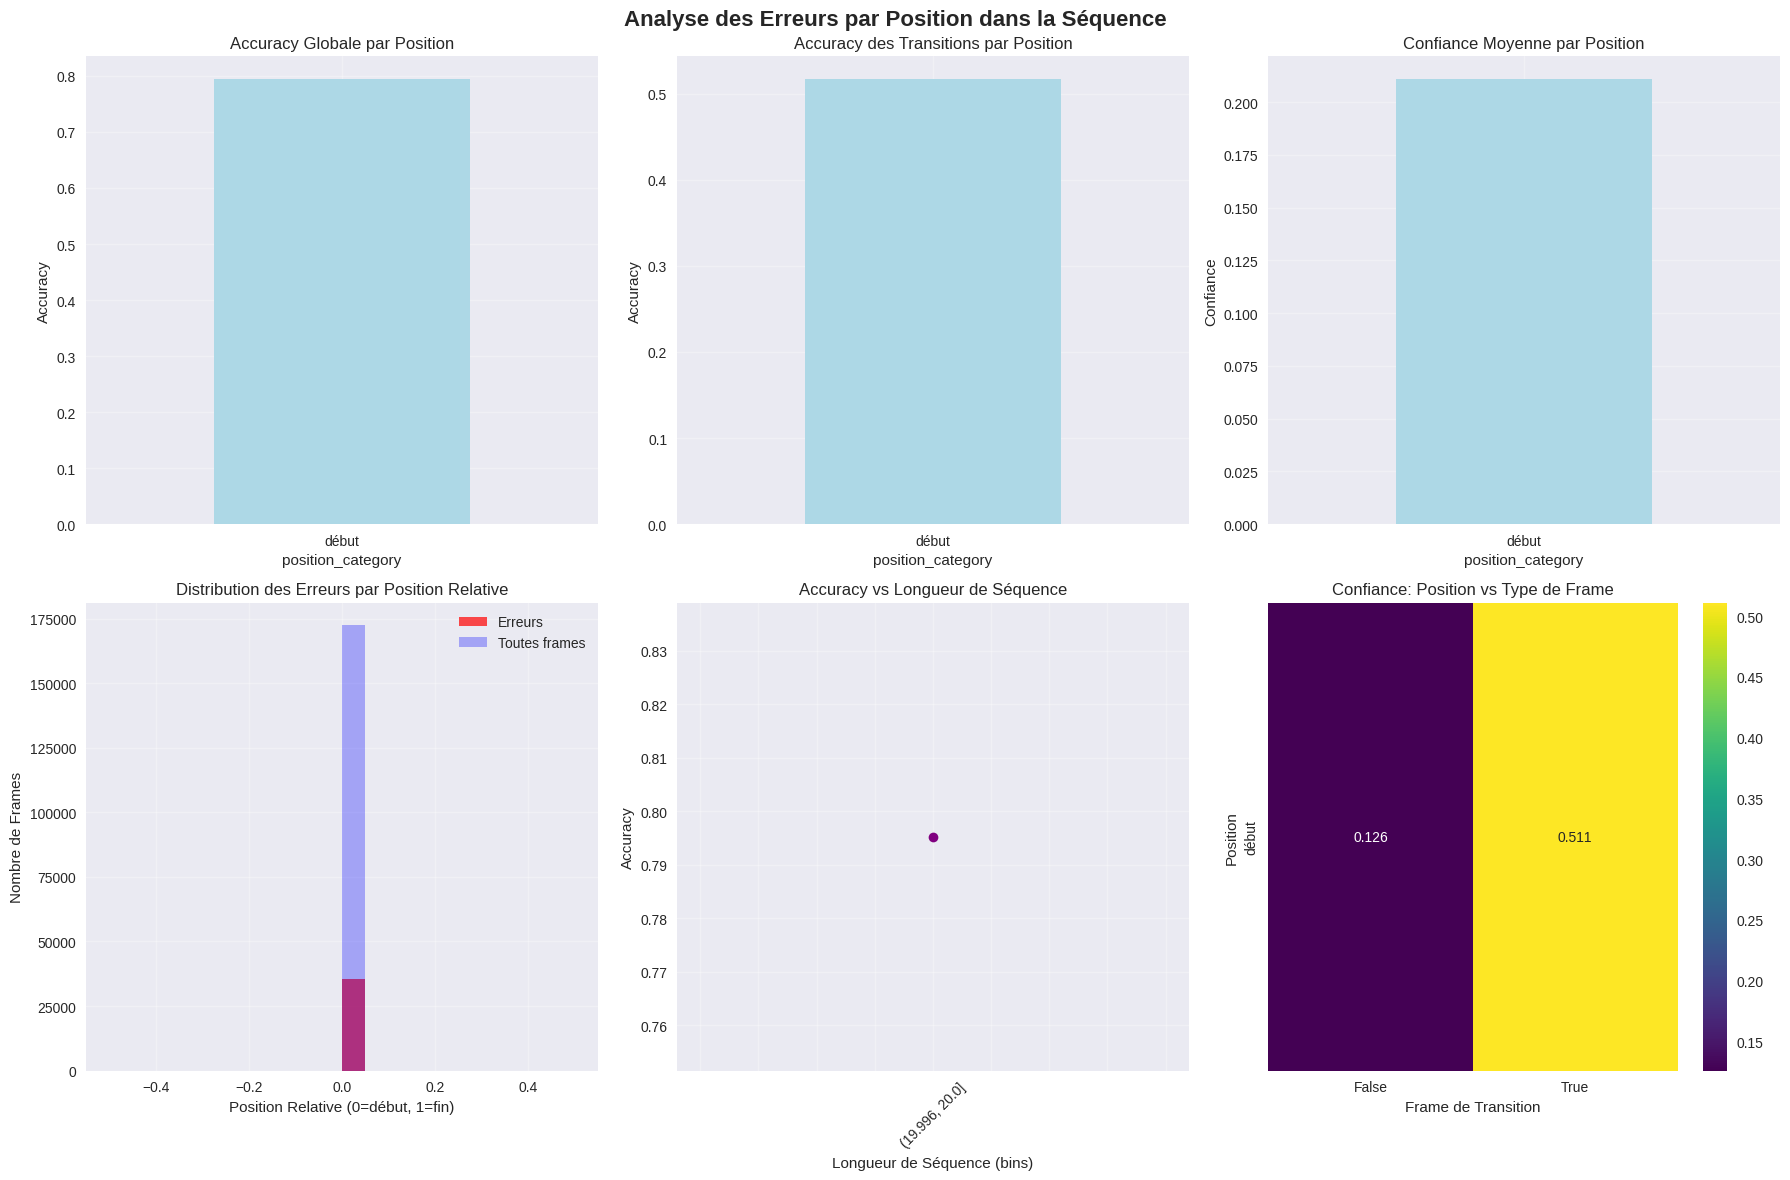


=== RÉSUMÉ PAR POSITION ===
Début: Accuracy=0.795, Confiance=0.211, Ratio transitions=0.222


In [11]:
# Visualisation des erreurs par position
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Analyse des Erreurs par Position dans la Séquence', fontsize=16, fontweight='bold')

# 1. Accuracy par position (toutes frames)
ax1 = axes[0, 0]
position_accuracy.plot(kind='bar', ax=ax1, color=['lightblue', 'lightgreen', 'lightcoral'])
ax1.set_title('Accuracy Globale par Position')
ax1.set_ylabel('Accuracy')
ax1.tick_params(axis='x', rotation=0)
ax1.grid(True, alpha=0.3)

# 2. Accuracy par position (frames de transition uniquement)
ax2 = axes[0, 1]
if len(transition_position_accuracy) > 0:
    transition_position_accuracy.plot(kind='bar', ax=ax2, color=['lightblue', 'lightgreen', 'lightcoral'])
ax2.set_title('Accuracy des Transitions par Position')
ax2.set_ylabel('Accuracy')
ax2.tick_params(axis='x', rotation=0)
ax2.grid(True, alpha=0.3)

# 3. Confiance par position
ax3 = axes[0, 2]
position_confidence.plot(kind='bar', ax=ax3, color=['lightblue', 'lightgreen', 'lightcoral'])
ax3.set_title('Confiance Moyenne par Position')
ax3.set_ylabel('Confiance')
ax3.tick_params(axis='x', rotation=0)
ax3.grid(True, alpha=0.3)

# 4. Distribution des erreurs par position relative (continue)
ax4 = axes[1, 0]
error_frames = position_df[position_df['correct'] == False]
if len(error_frames) > 0:
    ax4.hist(error_frames['relative_position'], bins=20, alpha=0.7, color='red', label='Erreurs')
ax4.hist(position_df['relative_position'], bins=20, alpha=0.3, color='blue', label='Toutes frames')
ax4.set_title('Distribution des Erreurs par Position Relative')
ax4.set_xlabel('Position Relative (0=début, 1=fin)')
ax4.set_ylabel('Nombre de Frames')
ax4.legend()
ax4.grid(True, alpha=0.3)

# 5. Accuracy vs longueur de séquence
ax5 = axes[1, 1]
seq_length_bins = pd.cut(position_df['sequence_length'], bins=10)
seq_length_accuracy = position_df.groupby(seq_length_bins)['correct'].mean()
seq_length_accuracy.plot(kind='line', ax=ax5, marker='o', color='purple')
ax5.set_title('Accuracy vs Longueur de Séquence')
ax5.set_xlabel('Longueur de Séquence (bins)')
ax5.set_ylabel('Accuracy')
ax5.tick_params(axis='x', rotation=45)
ax5.grid(True, alpha=0.3)

# 6. Heatmap confiance par position et type de frame
ax6 = axes[1, 2]
heatmap_data = position_df.pivot_table(values='confidence', 
                                       index='position_category', 
                                       columns='transition_frame', 
                                       aggfunc='mean')
sns.heatmap(heatmap_data, ax=ax6, annot=True, fmt='.3f', cmap='viridis')
ax6.set_title('Confiance: Position vs Type de Frame')
ax6.set_xlabel('Frame de Transition')
ax6.set_ylabel('Position')

plt.tight_layout()
plt.show()

print("\n=== RÉSUMÉ PAR POSITION ===")
for pos in ['début', 'milieu', 'fin']:
    subset = position_df[position_df['position_category'] == pos]
    if len(subset) > 0:
        accuracy = subset['correct'].mean()
        confidence = subset['confidence'].mean()
        transition_ratio = subset['transition_frame'].mean()
        print(f"{pos.capitalize()}: Accuracy={accuracy:.3f}, Confiance={confidence:.3f}, Ratio transitions={transition_ratio:.3f}")

In [12]:
def analyze_model_calibration(predictions, labels, scores):
    """Analyser la calibration du modèle (relation entre confiance et accuracy)"""
    all_frame_data = []
    
    for seq_idx, (pred_seq, label_seq, score_seq) in enumerate(zip(predictions, labels, scores)):
        for frame_idx, (pred, label, score) in enumerate(zip(pred_seq, label_seq, score_seq)):
            all_frame_data.append({
                'sequence_idx': seq_idx,
                'frame_idx': frame_idx,
                'prediction': pred,
                'true_label': label,
                'confidence': score,
                'correct': pred == label,
                'predicted_positive': pred == 1,
                'true_positive': label == 1
            })
    
    return pd.DataFrame(all_frame_data)

# Analyser la calibration
calibration_df = analyze_model_calibration(predictions, labels, scores)

print("=== ANALYSE DE CALIBRATION ===")
print(f"Nombre total de frames: {len(calibration_df)}")
print(f"Accuracy globale: {calibration_df['correct'].mean():.3f}")

# Analyser par bins de confiance
confidence_bins = pd.cut(calibration_df['confidence'], bins=10, include_lowest=True)
confidence_analysis = calibration_df.groupby(confidence_bins).agg({
    'correct': ['mean', 'count'],
    'confidence': 'mean',
    'predicted_positive': 'mean',
    'true_positive': 'mean'
})

print("\nCalibration par bins de confiance:")
print(confidence_analysis.round(3))

=== ANALYSE DE CALIBRATION ===
Nombre total de frames: 172580
Accuracy globale: 0.795

Calibration par bins de confiance:
                              correct         confidence predicted_positive  \
                                 mean   count       mean               mean   
confidence                                                                    
(-0.0019890000000000003, 0.1]   0.869  133027      0.001                0.0   
(0.1, 0.2]                      0.674    1069      0.146                0.0   
(0.2, 0.3]                      0.668     692      0.247                0.0   
(0.3, 0.4]                      0.577     542      0.351                0.0   
(0.4, 0.5]                      0.555     587      0.452                0.0   
(0.5, 0.6]                      0.452     706      0.549                1.0   
(0.6, 0.7]                      0.534     710      0.653                1.0   
(0.7, 0.8]                      0.538     916      0.753                1.0   
(0.8, 0.9

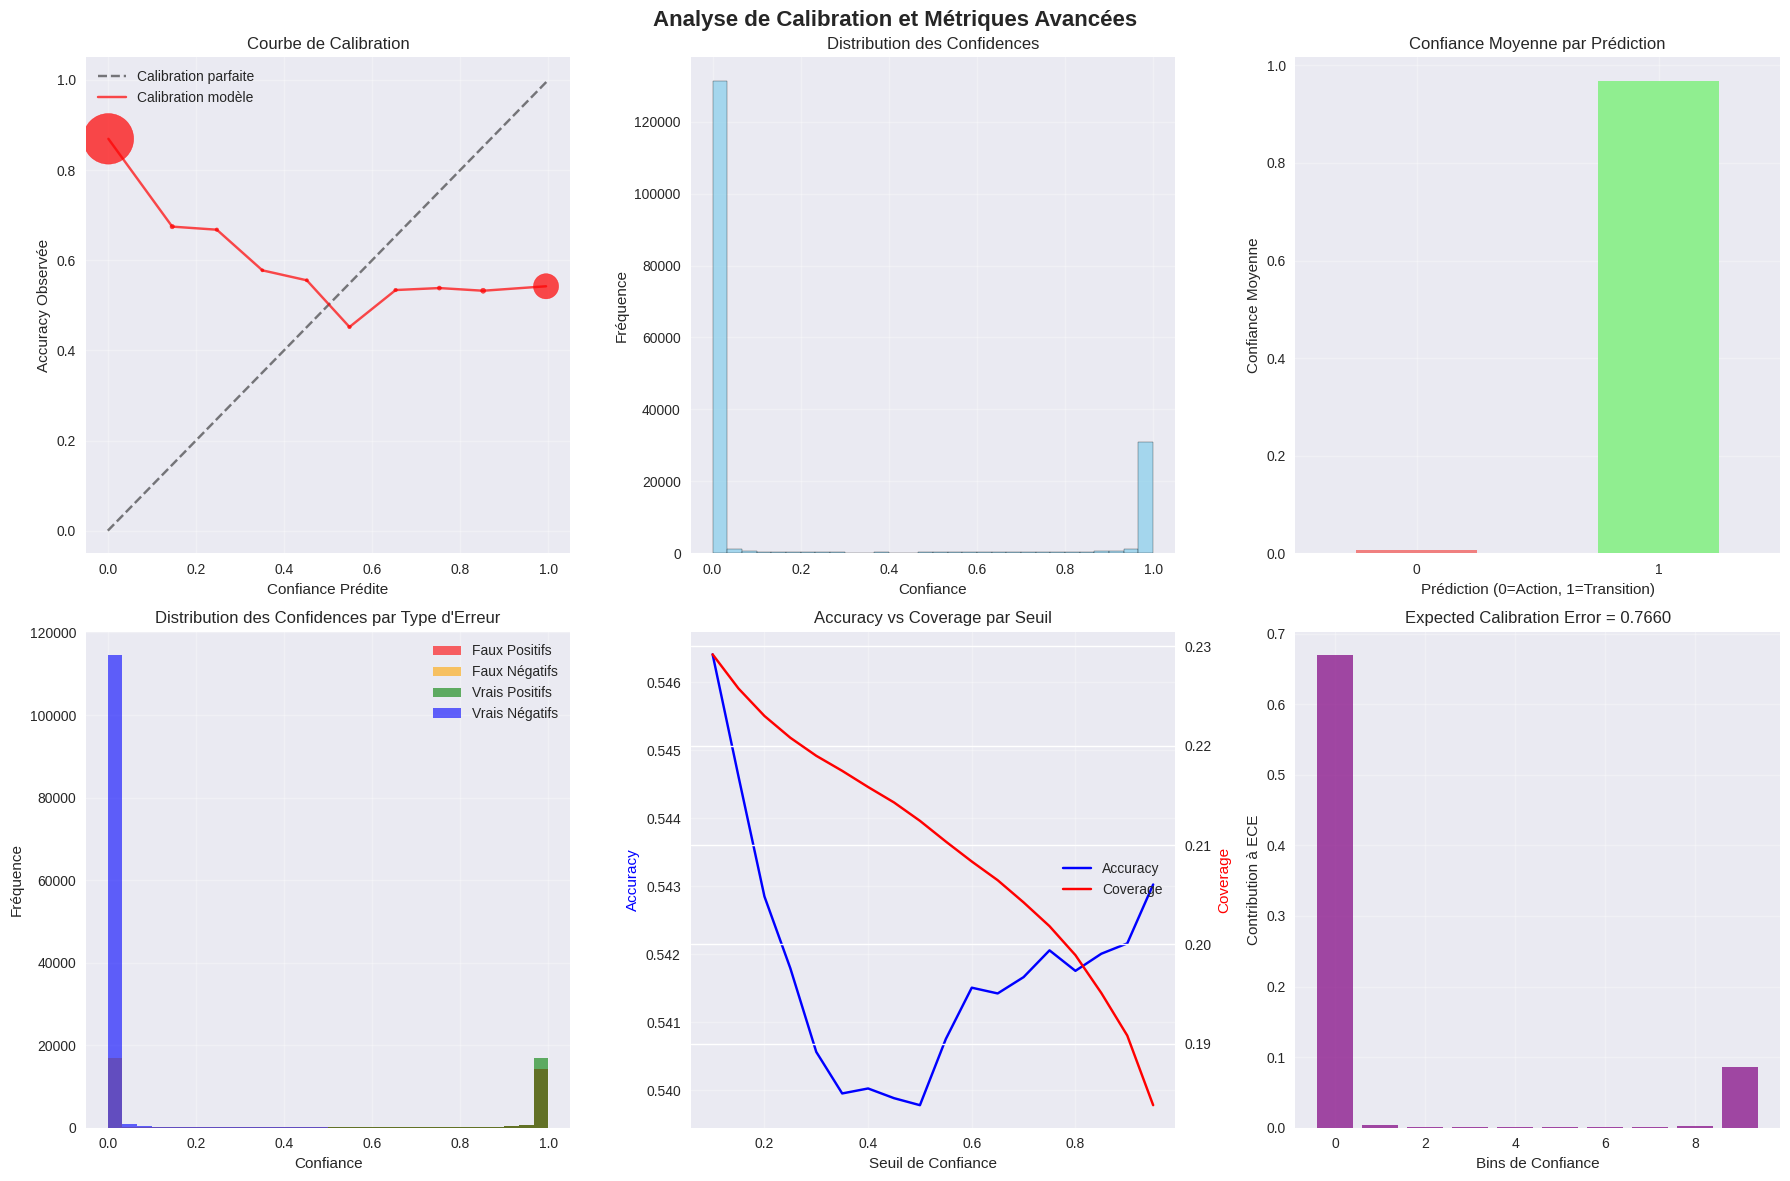


=== MÉTRIQUES DE CALIBRATION ===
Expected Calibration Error (ECE): 0.7660
Confiance moyenne: 0.211
Confiance médiane: 0.000
Écart-type confiance: 0.397


In [13]:
# Visualisation de la calibration
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Analyse de Calibration et Métriques Avancées', fontsize=16, fontweight='bold')

# 1. Courbe de calibration
ax1 = axes[0, 0]
conf_bins = np.linspace(0, 1, 11)
bin_centers = (conf_bins[:-1] + conf_bins[1:]) / 2
bin_accuracies = []
bin_confidences = []
bin_counts = []

for i in range(len(conf_bins)-1):
    mask = (calibration_df['confidence'] >= conf_bins[i]) & (calibration_df['confidence'] < conf_bins[i+1])
    subset = calibration_df[mask]
    if len(subset) > 0:
        bin_accuracies.append(subset['correct'].mean())
        bin_confidences.append(subset['confidence'].mean())
        bin_counts.append(len(subset))
    else:
        bin_accuracies.append(0)
        bin_confidences.append(conf_bins[i])
        bin_counts.append(0)

ax1.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Calibration parfaite')
ax1.scatter(bin_confidences, bin_accuracies, s=[c/100 for c in bin_counts], alpha=0.7, color='red')
ax1.plot(bin_confidences, bin_accuracies, 'r-', alpha=0.7, label='Calibration modèle')
ax1.set_xlabel('Confiance Prédite')
ax1.set_ylabel('Accuracy Observée')
ax1.set_title('Courbe de Calibration')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Distribution des confidences
ax2 = axes[0, 1]
calibration_df['confidence'].hist(bins=30, ax=ax2, alpha=0.7, color='skyblue', edgecolor='black')
ax2.set_xlabel('Confiance')
ax2.set_ylabel('Fréquence')
ax2.set_title('Distribution des Confidences')
ax2.grid(True, alpha=0.3)

# 3. Confiance par classe prédite
ax3 = axes[0, 2]
conf_by_pred = calibration_df.groupby('prediction')['confidence'].mean()
conf_by_pred.plot(kind='bar', ax=ax3, color=['lightcoral', 'lightgreen'])
ax3.set_title('Confiance Moyenne par Prédiction')
ax3.set_xlabel('Prédiction (0=Action, 1=Transition)')
ax3.set_ylabel('Confiance Moyenne')
ax3.tick_params(axis='x', rotation=0)
ax3.grid(True, alpha=0.3)

# 4. Analyse des faux positifs et faux négatifs par confiance
ax4 = axes[1, 0]
fp_mask = (calibration_df['prediction'] == 1) & (calibration_df['true_label'] == 0)
fn_mask = (calibration_df['prediction'] == 0) & (calibration_df['true_label'] == 1)
tp_mask = (calibration_df['prediction'] == 1) & (calibration_df['true_label'] == 1)
tn_mask = (calibration_df['prediction'] == 0) & (calibration_df['true_label'] == 0)

for mask, label, color in [(fp_mask, 'Faux Positifs', 'red'), 
                          (fn_mask, 'Faux Négatifs', 'orange'),
                          (tp_mask, 'Vrais Positifs', 'green'),
                          (tn_mask, 'Vrais Négatifs', 'blue')]:
    if mask.sum() > 0:
        ax4.hist(calibration_df[mask]['confidence'], bins=15, alpha=0.6, label=label, color=color)

ax4.set_xlabel('Confiance')
ax4.set_ylabel('Fréquence')
ax4.set_title('Distribution des Confidences par Type d\'Erreur')
ax4.legend()
ax4.grid(True, alpha=0.3)

# 5. Évolution de l'accuracy avec le seuil de confiance
ax5 = axes[1, 1]
thresholds = np.arange(0.1, 1.0, 0.05)
accuracies_at_threshold = []
coverage_at_threshold = []

for threshold in thresholds:
    high_conf_mask = calibration_df['confidence'] >= threshold
    if high_conf_mask.sum() > 0:
        acc = calibration_df[high_conf_mask]['correct'].mean()
        cov = high_conf_mask.mean()
    else:
        acc = 0
        cov = 0
    accuracies_at_threshold.append(acc)
    coverage_at_threshold.append(cov)

ax5_twin = ax5.twinx()
line1 = ax5.plot(thresholds, accuracies_at_threshold, 'b-', label='Accuracy')
line2 = ax5_twin.plot(thresholds, coverage_at_threshold, 'r-', label='Coverage')
ax5.set_xlabel('Seuil de Confiance')
ax5.set_ylabel('Accuracy', color='b')
ax5_twin.set_ylabel('Coverage', color='r')
ax5.set_title('Accuracy vs Coverage par Seuil')
ax5.grid(True, alpha=0.3)

# Légende combinée
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax5.legend(lines, labels, loc='center right')

# 6. ECE (Expected Calibration Error)
ax6 = axes[1, 2]
ece_bins = 10
conf_bin_edges = np.linspace(0, 1, ece_bins + 1)
ece_values = []

for i in range(ece_bins):
    mask = (calibration_df['confidence'] >= conf_bin_edges[i]) & (calibration_df['confidence'] < conf_bin_edges[i+1])
    if i == ece_bins - 1:  # Dernier bin inclut la borne supérieure
        mask = (calibration_df['confidence'] >= conf_bin_edges[i]) & (calibration_df['confidence'] <= conf_bin_edges[i+1])
    
    subset = calibration_df[mask]
    if len(subset) > 0:
        bin_acc = subset['correct'].mean()
        bin_conf = subset['confidence'].mean()
        bin_weight = len(subset) / len(calibration_df)
        ece_contribution = abs(bin_acc - bin_conf) * bin_weight
        ece_values.append(ece_contribution)
    else:
        ece_values.append(0)

ece_score = sum(ece_values)
ax6.bar(range(ece_bins), ece_values, alpha=0.7, color='purple')
ax6.set_xlabel('Bins de Confiance')
ax6.set_ylabel('Contribution à ECE')
ax6.set_title(f'Expected Calibration Error = {ece_score:.4f}')
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n=== MÉTRIQUES DE CALIBRATION ===")
print(f"Expected Calibration Error (ECE): {ece_score:.4f}")
print(f"Confiance moyenne: {calibration_df['confidence'].mean():.3f}")
print(f"Confiance médiane: {calibration_df['confidence'].median():.3f}")
print(f"Écart-type confiance: {calibration_df['confidence'].std():.3f}")

In [14]:
def analyze_transition_patterns(predictions, labels, scores):
    """Analyser les patterns complexes de transitions"""
    pattern_analysis = []
    
    for seq_idx, (pred_seq, label_seq, score_seq) in enumerate(zip(predictions, labels, scores)):
        # Détecter les transitions consécutives
        gt_segments = extract_segments(label_seq)
        pred_segments = extract_segments(pred_seq)
        
        # Compter les transitions dans la séquence
        gt_transitions = [seg for seg in gt_segments if seg[0] == 1]
        pred_transitions = [seg for seg in pred_segments if seg[0] == 1]
        
        # Analyser les gaps entre transitions
        gt_gaps = []
        if len(gt_transitions) > 1:
            for i in range(len(gt_transitions) - 1):
                gap = gt_transitions[i+1][1] - gt_transitions[i][2]  # start_next - end_current
                gt_gaps.append(gap)
        
        # Pattern d'erreurs
        false_positives = np.sum((pred_seq == 1) & (label_seq == 0))
        false_negatives = np.sum((pred_seq == 0) & (label_seq == 1))
        
        # Analyse de la fragmentation des prédictions
        pred_transition_segments = len([seg for seg in pred_segments if seg[0] == 1])
        gt_transition_segments = len(gt_transitions)
        
        pattern_analysis.append({
            'sequence_idx': seq_idx,
            'sequence_length': len(label_seq),
            'gt_num_transitions': gt_transition_segments,
            'pred_num_transitions': pred_transition_segments,
            'transition_over_segmentation': pred_transition_segments - gt_transition_segments,
            'false_positives': false_positives,
            'false_negatives': false_negatives,
            'avg_gt_gap': np.mean(gt_gaps) if gt_gaps else 0,
            'min_gt_gap': np.min(gt_gaps) if gt_gaps else 0,
            'has_multiple_transitions': len(gt_transitions) > 1,
            'transition_density': len(gt_transitions) / len(label_seq),
            'avg_confidence_transitions': np.mean([score_seq[start:end].mean() 
                                                 for _, start, end in gt_transitions]) if gt_transitions else 0
        })
    
    return pd.DataFrame(pattern_analysis)

# Analyser les patterns
pattern_df = analyze_transition_patterns(predictions, labels, scores)

print("=== ANALYSE DES PATTERNS DE TRANSITION ===")
print(f"Séquences avec transitions multiples: {pattern_df['has_multiple_transitions'].sum()} / {len(pattern_df)}")
print(f"Densité moyenne de transitions: {pattern_df['transition_density'].mean():.4f}")
print(f"Sur-segmentation moyenne: {pattern_df['transition_over_segmentation'].mean():.2f}")

print("\nErreurs par nombre de transitions:")
for num_trans in sorted(pattern_df['gt_num_transitions'].unique()):
    subset = pattern_df[pattern_df['gt_num_transitions'] == num_trans]
    if len(subset) > 0:
        avg_fp = subset['false_positives'].mean()
        avg_fn = subset['false_negatives'].mean()
        print(f"  {num_trans} transition(s): FP={avg_fp:.1f}, FN={avg_fn:.1f} (n={len(subset)})")

=== ANALYSE DES PATTERNS DE TRANSITION ===
Séquences avec transitions multiples: 0 / 2
Densité moyenne de transitions: 0.0000
Sur-segmentation moyenne: 0.00

Erreurs par nombre de transitions:
  0 transition(s): FP=0.0, FN=0.0 (n=2)


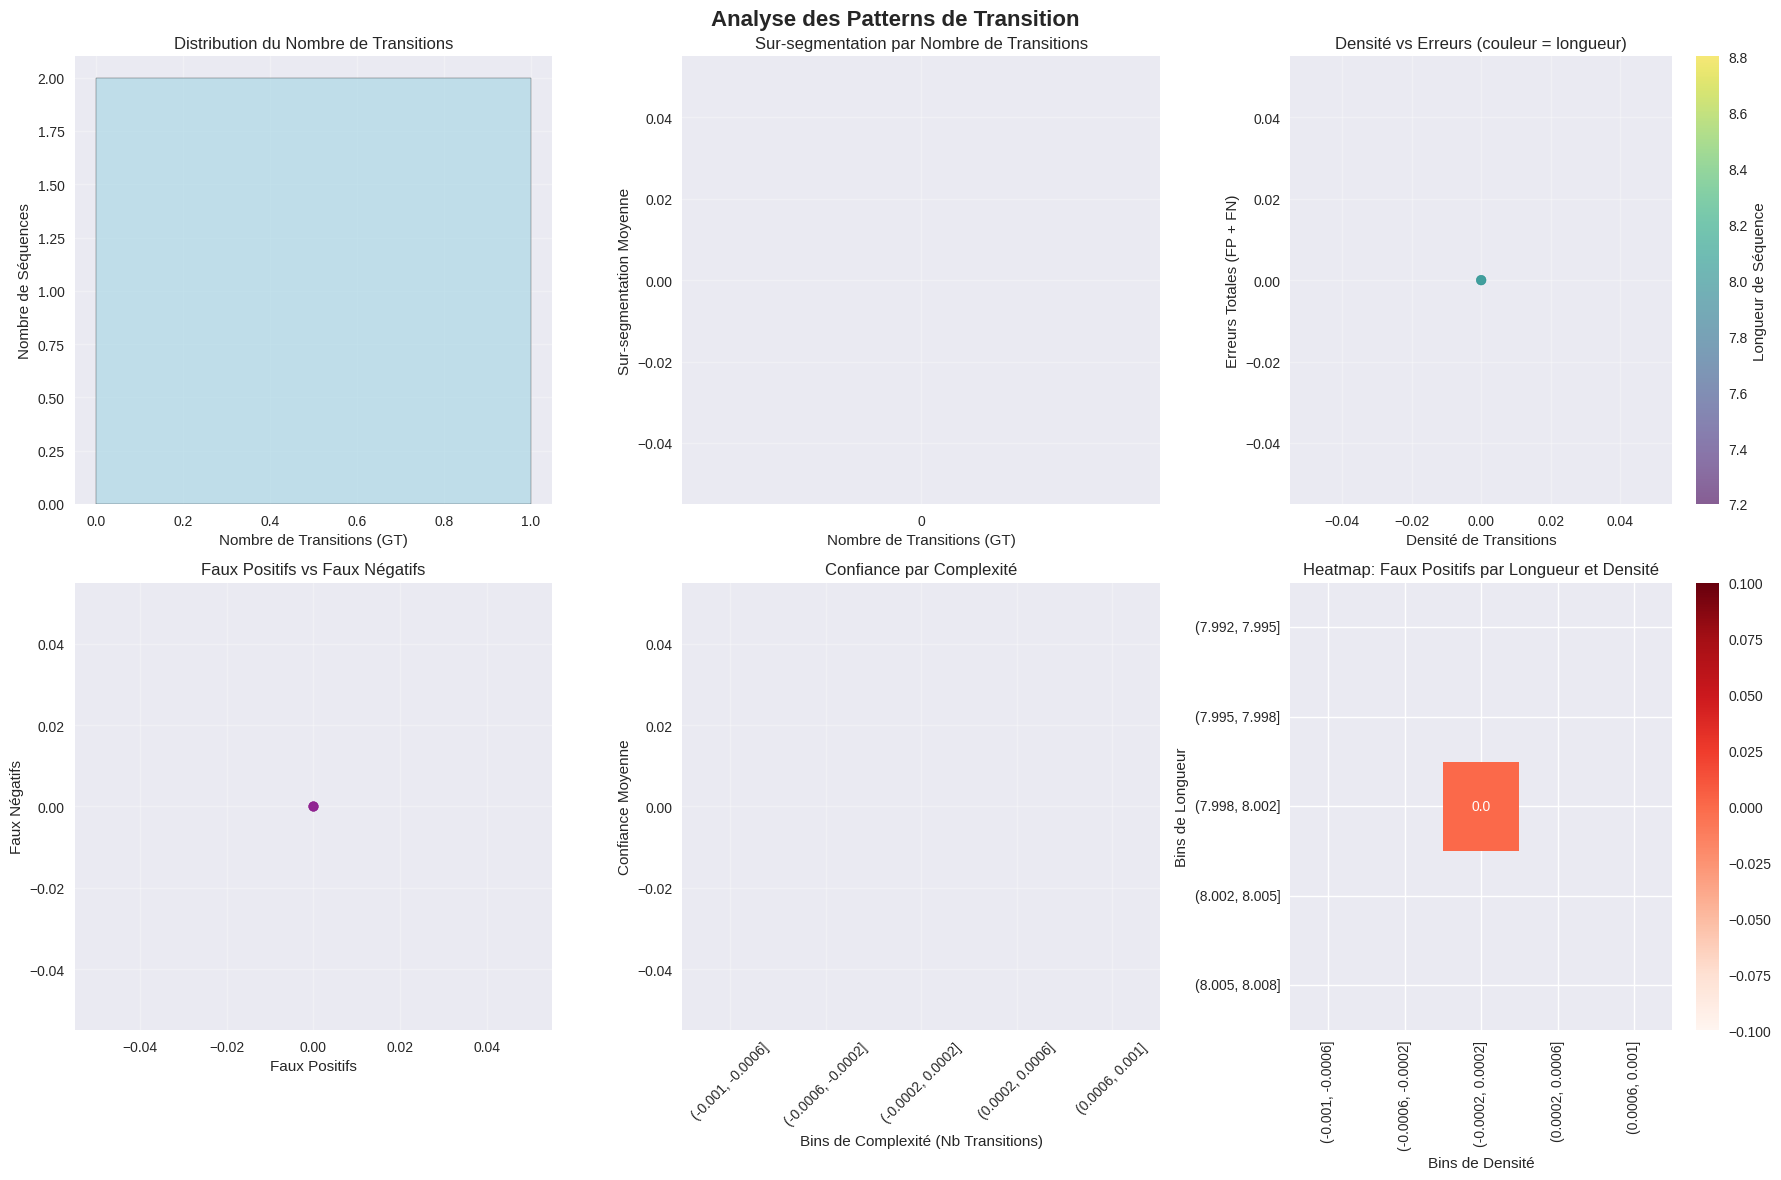


=== SÉQUENCES PROBLÉMATIQUES ===
Séquences avec beaucoup d'erreurs (top 10%): 0

Séquences sur-segmentées (>2 segments extra): 0


In [15]:
# Visualisation des patterns de transition
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Analyse des Patterns de Transition', fontsize=16, fontweight='bold')

# 1. Distribution du nombre de transitions par séquence
ax1 = axes[0, 0]
pattern_df['gt_num_transitions'].hist(bins=range(0, pattern_df['gt_num_transitions'].max()+2), 
                                     ax=ax1, alpha=0.7, color='lightblue', edgecolor='black')
ax1.set_xlabel('Nombre de Transitions (GT)')
ax1.set_ylabel('Nombre de Séquences')
ax1.set_title('Distribution du Nombre de Transitions')
ax1.grid(True, alpha=0.3)

# 2. Sur-segmentation vs nombre de transitions
ax2 = axes[0, 1]
over_seg_by_num = pattern_df.groupby('gt_num_transitions')['transition_over_segmentation'].mean()
over_seg_by_num.plot(kind='bar', ax=ax2, color='lightcoral')
ax2.set_xlabel('Nombre de Transitions (GT)')
ax2.set_ylabel('Sur-segmentation Moyenne')
ax2.set_title('Sur-segmentation par Nombre de Transitions')
ax2.tick_params(axis='x', rotation=0)
ax2.grid(True, alpha=0.3)

# 3. Densité de transitions vs erreurs
ax3 = axes[0, 2]
scatter = ax3.scatter(pattern_df['transition_density'], 
                     pattern_df['false_positives'] + pattern_df['false_negatives'],
                     alpha=0.6, c=pattern_df['sequence_length'], cmap='viridis')
ax3.set_xlabel('Densité de Transitions')
ax3.set_ylabel('Erreurs Totales (FP + FN)')
ax3.set_title('Densité vs Erreurs (couleur = longueur)')
cbar = plt.colorbar(scatter, ax=ax3)
cbar.set_label('Longueur de Séquence')
ax3.grid(True, alpha=0.3)

# 4. Faux positifs vs faux négatifs
ax4 = axes[1, 0]
ax4.scatter(pattern_df['false_positives'], pattern_df['false_negatives'], 
           alpha=0.6, color='purple')
ax4.set_xlabel('Faux Positifs')
ax4.set_ylabel('Faux Négatifs')
ax4.set_title('Faux Positifs vs Faux Négatifs')
ax4.grid(True, alpha=0.3)

# 5. Confiance par complexité de séquence
ax5 = axes[1, 1]
complexity_bins = pd.cut(pattern_df['gt_num_transitions'], bins=5)
conf_by_complexity = pattern_df.groupby(complexity_bins)['avg_confidence_transitions'].mean()
conf_by_complexity.plot(kind='bar', ax=ax5, color='lightgreen')
ax5.set_xlabel('Bins de Complexité (Nb Transitions)')
ax5.set_ylabel('Confiance Moyenne')
ax5.set_title('Confiance par Complexité')
ax5.tick_params(axis='x', rotation=45)
ax5.grid(True, alpha=0.3)

# 6. Heatmap erreurs par longueur et densité
ax6 = axes[1, 2]
length_bins = pd.cut(pattern_df['sequence_length'], bins=5)
density_bins = pd.cut(pattern_df['transition_density'], bins=5)
error_heatmap = pattern_df.groupby([length_bins, density_bins])['false_positives'].mean().unstack(fill_value=0)
sns.heatmap(error_heatmap, ax=ax6, cmap='Reds', annot=True, fmt='.1f')
ax6.set_title('Heatmap: Faux Positifs par Longueur et Densité')
ax6.set_xlabel('Bins de Densité')
ax6.set_ylabel('Bins de Longueur')

plt.tight_layout()
plt.show()

# Analyse détaillée des séquences problématiques
print("\n=== SÉQUENCES PROBLÉMATIQUES ===")

# Séquences avec beaucoup d'erreurs
high_error_threshold = pattern_df['false_positives'].quantile(0.9) + pattern_df['false_negatives'].quantile(0.9)
problematic_seqs = pattern_df[
    (pattern_df['false_positives'] + pattern_df['false_negatives']) > high_error_threshold
]

print(f"Séquences avec beaucoup d'erreurs (top 10%): {len(problematic_seqs)}")
if len(problematic_seqs) > 0:
    print("Caractéristiques moyennes:")
    print(f"  - Longueur: {problematic_seqs['sequence_length'].mean():.1f}")
    print(f"  - Nombre de transitions: {problematic_seqs['gt_num_transitions'].mean():.1f}")
    print(f"  - Densité: {problematic_seqs['transition_density'].mean():.4f}")
    print(f"  - Sur-segmentation: {problematic_seqs['transition_over_segmentation'].mean():.1f}")

# Séquences avec forte sur-segmentation
over_segmented = pattern_df[pattern_df['transition_over_segmentation'] > 2]
print(f"\nSéquences sur-segmentées (>2 segments extra): {len(over_segmented)}")
if len(over_segmented) > 0:
    print(f"  - Sur-segmentation moyenne: {over_segmented['transition_over_segmentation'].mean():.1f}")
    print(f"  - Faux positifs moyens: {over_segmented['false_positives'].mean():.1f}")

## Synthèse de l'Analyse

Cette analyse complète examine les performances de votre modèle de segmentation action/transition sous plusieurs angles :

### 📊 Métriques Analysées

1. **Erreurs par longueur de transition** - Comprendre si le modèle a des difficultés avec les transitions courtes/longues
2. **Erreurs par position dans la séquence** - Détecter des biais début/milieu/fin
3. **Calibration du modèle** - Évaluer la fiabilité des scores de confiance
4. **Patterns de transition complexes** - Analyser les séquences avec transitions multiples

### 🎯 Points Clés à Examiner

- **ECE (Expected Calibration Error)** : Plus proche de 0 = meilleure calibration
- **Sur-segmentation** : Valeurs positives = le modèle prédit trop de segments
- **Distribution des erreurs** : Identifier les types de séquences problématiques
- **Confiance vs Accuracy** : Vérifier si le modèle est "sûr" de ses erreurs

### 🔍 Interprétation des Résultats

Utilisez ces visualisations pour :
- Identifier les faiblesses spécifiques du modèle
- Comprendre quand ajuster les seuils de confiance
- Orienter les améliorations d'architecture ou d'entraînement
- Détecter les biais dans les données ou l'apprentissage

In [16]:
# Sauvegarder les résultats de l'analyse
analysis_results = {
    'model_info': {
        'run_dir': run_dir,
        'window_size': window_size,
        'num_sequences': len(predictions),
        'total_frames': len(calibration_df)
    },
    'global_metrics': {
        'overall_accuracy': calibration_df['correct'].mean(),
        'ece_score': ece_score,
        'mean_confidence': calibration_df['confidence'].mean(),
        'std_confidence': calibration_df['confidence'].std()
    },
    'transition_analysis': {
        'avg_transition_length': transition_df['transition_length'].mean(),
        'accuracy_by_length': transition_df.groupby('transition_length')['correct_ratio'].mean().to_dict()
    },
    'position_analysis': {
        'accuracy_by_position': position_accuracy.to_dict(),
        'confidence_by_position': position_confidence.to_dict()
    },
    'pattern_analysis': {
        'sequences_with_multiple_transitions': pattern_df['has_multiple_transitions'].sum(),
        'avg_transition_density': pattern_df['transition_density'].mean(),
        'avg_over_segmentation': pattern_df['transition_over_segmentation'].mean()
    }
}

# Sauvegarder en JSON
analysis_dir = os.path.join(run_dir, "detailed_analysis")
os.makedirs(analysis_dir, exist_ok=True)

with open(os.path.join(analysis_dir, "analysis_results.json"), 'w') as f:
    json.dump(analysis_results, f, indent=2)

# Sauvegarder les DataFrames
transition_df.to_csv(os.path.join(analysis_dir, "transition_analysis.csv"), index=False)
position_df.to_csv(os.path.join(analysis_dir, "position_analysis.csv"), index=False)
calibration_df.to_csv(os.path.join(analysis_dir, "calibration_analysis.csv"), index=False)
pattern_df.to_csv(os.path.join(analysis_dir, "pattern_analysis.csv"), index=False)

print(f"\n=== ANALYSE SAUVEGARDÉE ===")
print(f"Dossier: {analysis_dir}")
print(f"Fichiers générés:")
print(f"  - analysis_results.json")
print(f"  - transition_analysis.csv")
print(f"  - position_analysis.csv")
print(f"  - calibration_analysis.csv")
print(f"  - pattern_analysis.csv")

print(f"\n🎯 RÉSUMÉ EXÉCUTIF:")
print(f"Accuracy globale: {analysis_results['global_metrics']['overall_accuracy']:.3f}")
print(f"ECE (calibration): {analysis_results['global_metrics']['ece_score']:.4f}")
print(f"Longueur moyenne des transitions: {analysis_results['transition_analysis']['avg_transition_length']:.1f} frames")
print(f"Séquences complexes (>1 transition): {analysis_results['pattern_analysis']['sequences_with_multiple_transitions']}")
print(f"Sur-segmentation moyenne: {analysis_results['pattern_analysis']['avg_over_segmentation']:.2f}")

TypeError: Object of type float32 is not JSON serializable


=== ANALYSE DE SÉQUENCES SPÉCIFIQUES ===

Analyse d'une séquence avec bonne performance (idx 0):


ValueError: x and y must have same first dimension, but have shapes (1,) and (20,)

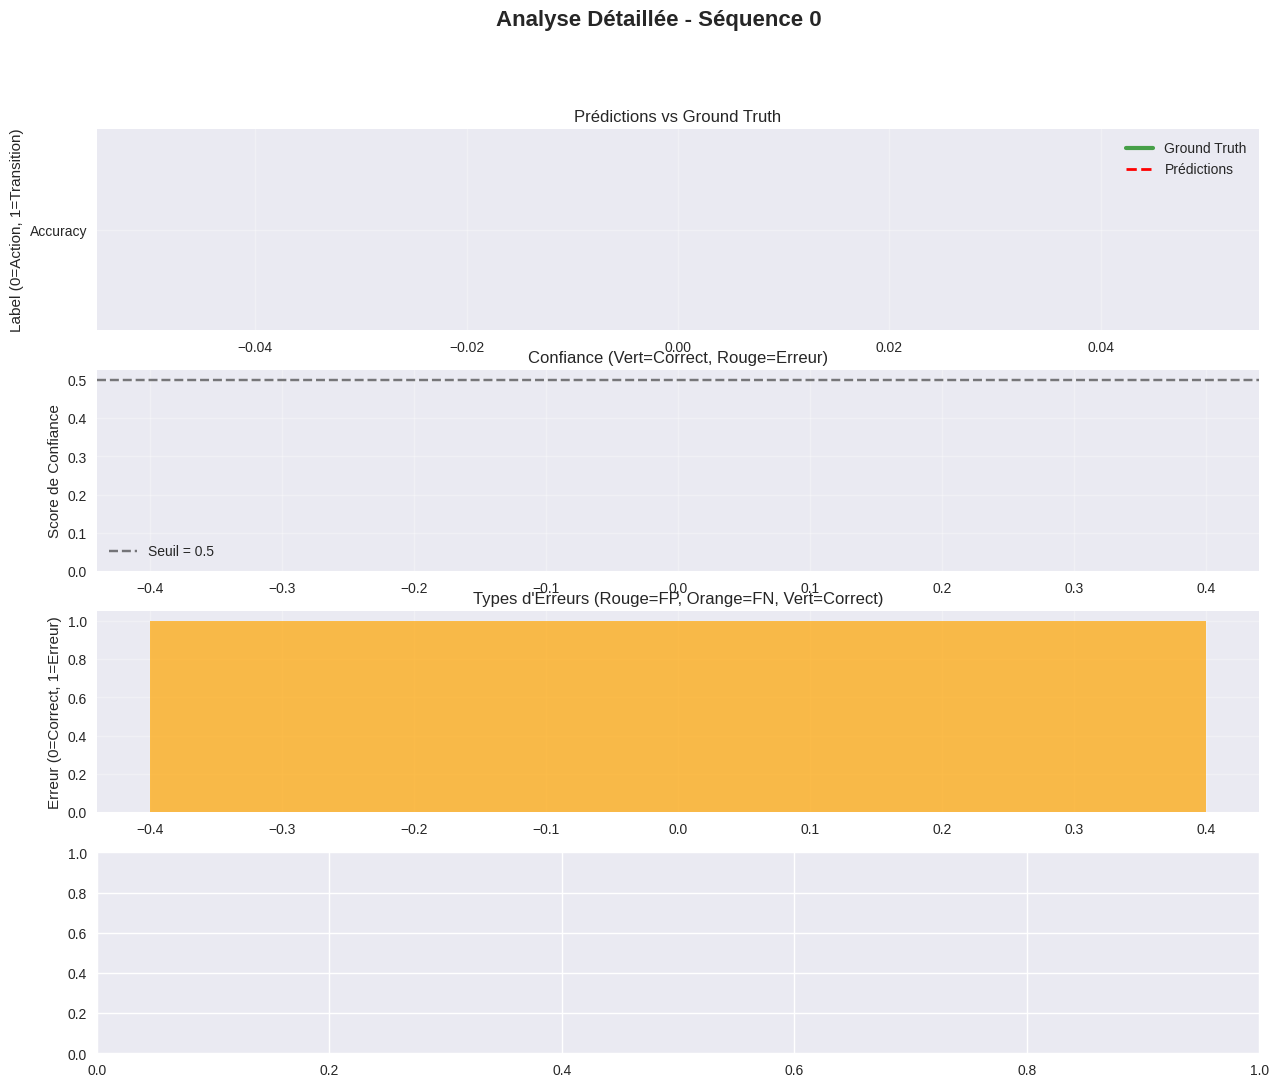

In [17]:
# Analyser une séquence spécifique en détail
def visualize_sequence_prediction(seq_idx, predictions, labels, scores, motion_data):
    """Visualiser en détail une séquence spécifique"""
    pred_seq = predictions[seq_idx]
    label_seq = labels[seq_idx]
    score_seq = scores[seq_idx]
    motion_seq = motion_data[seq_idx]
    
    fig, axes = plt.subplots(4, 1, figsize=(15, 12))
    fig.suptitle(f'Analyse Détaillée - Séquence {seq_idx}', fontsize=16, fontweight='bold')
    
    frames = range(len(pred_seq))
    
    # 1. Comparaison prédictions vs ground truth
    ax1 = axes[0]
    ax1.plot(frames, label_seq, 'g-', linewidth=3, label='Ground Truth', alpha=0.7)
    ax1.plot(frames, pred_seq, 'r--', linewidth=2, label='Prédictions')
    ax1.fill_between(frames, 0, label_seq, alpha=0.3, color='green')
    ax1.fill_between(frames, 0, pred_seq, alpha=0.3, color='red')
    ax1.set_ylabel('Label (0=Action, 1=Transition)')
    ax1.set_title('Prédictions vs Ground Truth')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Scores de confiance
    ax2 = axes[1]
    confidence_colors = ['red' if p != l else 'green' for p, l in zip(pred_seq, label_seq)]
    bars = ax2.bar(frames, score_seq, color=confidence_colors, alpha=0.7)
    ax2.axhline(y=0.5, color='black', linestyle='--', alpha=0.5, label='Seuil = 0.5')
    ax2.set_ylabel('Score de Confiance')
    ax2.set_title('Confiance (Vert=Correct, Rouge=Erreur)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Erreurs frame par frame
    ax3 = axes[2]
    errors = [1 if p != l else 0 for p, l in zip(pred_seq, label_seq)]
    error_types = []
    for p, l in zip(pred_seq, label_seq):
        if p == l:
            error_types.append('correct')
        elif p == 1 and l == 0:
            error_types.append('false_positive')
        else:
            error_types.append('false_negative')
    
    color_map = {'correct': 'green', 'false_positive': 'red', 'false_negative': 'orange'}
    colors = [color_map[et] for et in error_types]
    
    ax3.bar(frames, errors, color=colors, alpha=0.7)
    ax3.set_ylabel('Erreur (0=Correct, 1=Erreur)')
    ax3.set_title('Types d\'Erreurs (Rouge=FP, Orange=FN, Vert=Correct)')
    ax3.grid(True, alpha=0.3)
    
    # 4. Variabilité du mouvement (optionnel si motion disponible)
    ax4 = axes[3]
    if motion_seq is not None and len(motion_seq.shape) > 1:
        # Calculer la norme du mouvement comme proxy de l'activité
        motion_norm = np.linalg.norm(motion_seq, axis=1)
        ax4.plot(frames, motion_norm, 'b-', alpha=0.7, label='Amplitude du Mouvement')
        ax4.set_ylabel('Amplitude du Mouvement')
        ax4.set_xlabel('Frame')
        ax4.set_title('Amplitude du Mouvement')
        ax4.legend()
    else:
        ax4.text(0.5, 0.5, 'Données de mouvement non disponibles', 
                ha='center', va='center', transform=ax4.transAxes)
        ax4.set_xlabel('Frame')
    
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Statistiques de la séquence
    accuracy = np.mean(np.array(pred_seq) == np.array(label_seq))
    avg_confidence = np.mean(score_seq)
    num_transitions_gt = np.sum(label_seq)
    num_transitions_pred = np.sum(pred_seq)
    false_positives = np.sum((np.array(pred_seq) == 1) & (np.array(label_seq) == 0))
    false_negatives = np.sum((np.array(pred_seq) == 0) & (np.array(label_seq) == 1))
    
    print(f"\nSTATISTIQUES SÉQUENCE {seq_idx}:")
    print(f"Longueur: {len(pred_seq)} frames")
    print(f"Accuracy: {accuracy:.3f}")
    print(f"Confiance moyenne: {avg_confidence:.3f}")
    print(f"Transitions GT: {num_transitions_gt}, Prédites: {num_transitions_pred}")
    print(f"Faux positifs: {false_positives}, Faux négatifs: {false_negatives}")
    
    return {
        'accuracy': accuracy,
        'avg_confidence': avg_confidence,
        'false_positives': false_positives,
        'false_negatives': false_negatives
    }

# Analyser quelques séquences spécifiques
print("\n=== ANALYSE DE SÉQUENCES SPÉCIFIQUES ===")

# Séquence avec beaucoup d'erreurs
if len(problematic_seqs) > 0:
    worst_seq_idx = problematic_seqs.iloc[0]['sequence_idx']
    print(f"\nAnalyse de la séquence la plus problématique (idx {worst_seq_idx}):")
    visualize_sequence_prediction(worst_seq_idx, predictions, labels, scores, motion_data)

# Séquence avec bonne performance
best_seqs = pattern_df[
    (pattern_df['false_positives'] + pattern_df['false_negatives']) < 2
]
if len(best_seqs) > 0:
    best_seq_idx = best_seqs.iloc[0]['sequence_idx']
    print(f"\nAnalyse d'une séquence avec bonne performance (idx {best_seq_idx}):")
    visualize_sequence_prediction(best_seq_idx, predictions, labels, scores, motion_data)

## 🚀 Suggestions d'Amélioration

Basé sur cette analyse, voici des pistes d'amélioration :

### 🎯 Si le modèle a des problèmes de calibration (ECE élevé)
- Utiliser **temperature scaling** après l'entraînement
- Ajouter des techniques de **regularisation** (dropout, weight decay)
- Considérer l'**ensemble de modèles** pour améliorer la confiance

### 📏 Si les erreurs varient selon la longueur des transitions
- **Augmentation de données** ciblée sur les longueurs problématiques
- Utiliser des **pertes pondérées** selon la longueur
- Expérimenter avec différentes **tailles de fenêtres**

### 📍 Si les erreurs varient selon la position
- Vérifier les **biais dans les données d'entraînement**
- Utiliser de l'**augmentation positionnelle**
- Considérer des **architectures bidirectionnelles**

### 🔄 Si le modèle sur-segmente les transitions
- Ajuster le **seuil de décision** (au lieu de 0.5)
- Utiliser des techniques de **post-processing** (filtrage, smoothing)
- Ajouter une **perte de régularisation** pour la continuité

### 📊 Prochaines Étapes Recommandées
1. **Analyser plus de run_dirs** pour identifier les patterns récurrents
2. **Comparer différentes architectures** avec cette même analyse
3. **Tester différents seuils** de confiance pour optimiser precision/recall
4. **Analyser les échantillons difficiles** en détail pour comprendre les causes

In [18]:
# Fonction pour analyser rapidement d'autres modèles
def quick_analysis(run_dir_path, output_name=None):
    """Analyse rapide d'un autre modèle"""
    if output_name is None:
        output_name = os.path.basename(run_dir_path)
    
    print(f"\n{'='*50}")
    print(f"ANALYSE RAPIDE: {output_name}")
    print(f"{'='*50}")
    
    try:
        # Charger config et modèle
        cfg_temp = read_config(run_dir_path)
        model_temp = load_model_from_cfg(cfg_temp, ckpt_name, eval_mode=True, device=device)
        model_temp.eval()
        
        # Dataset
        window_size_temp = cfg_temp.data.window_size
        dataset_temp = instantiate(cfg_temp.data, window_size=window_size_temp, split="all", for_validation=True)
        
        # Prédictions (échantillon plus petit pour la rapidité)
        sample_size = min(100, len(dataset_temp))
        indices = np.random.choice(len(dataset_temp), sample_size, replace=False)
        
        quick_preds = []
        quick_labels = []
        quick_scores = []
        
        with torch.no_grad():
            for idx in tqdm(indices, desc=f"Analyse {output_name}"):
                sample = dataset_temp[idx]
                motion = sample["transformed_motion"].unsqueeze(0).to(device)
                label = sample["transition_mask"].numpy()
                
                batch_dict = {"transformed_motion": motion}
                logits = model_temp(batch_dict, None)
                prob = torch.sigmoid(logits).cpu().numpy()[0]
                pred = (prob > 0.5).astype(int)
                
                quick_preds.append(pred)
                quick_labels.append(label)
                quick_scores.append(prob)
        
        # Métriques rapides
        all_preds_flat = np.concatenate(quick_preds)
        all_labels_flat = np.concatenate(quick_labels)
        all_scores_flat = np.concatenate(quick_scores)
        
        accuracy = np.mean(all_preds_flat == all_labels_flat)
        avg_confidence = np.mean(all_scores_flat)
        
        # ECE rapide
        conf_bins = np.linspace(0, 1, 11)
        ece_quick = 0
        for i in range(len(conf_bins)-1):
            mask = (all_scores_flat >= conf_bins[i]) & (all_scores_flat < conf_bins[i+1])
            if mask.sum() > 0:
                bin_acc = (all_preds_flat[mask] == all_labels_flat[mask]).mean()
                bin_conf = all_scores_flat[mask].mean()
                bin_weight = mask.sum() / len(all_scores_flat)
                ece_quick += abs(bin_acc - bin_conf) * bin_weight
        
        print(f"📊 RÉSULTATS ({sample_size} séquences):")
        print(f"  Accuracy: {accuracy:.3f}")
        print(f"  Confiance moyenne: {avg_confidence:.3f}")
        print(f"  ECE: {ece_quick:.4f}")
        print(f"  Window size: {window_size_temp}")
        
        return {
            'name': output_name,
            'accuracy': accuracy,
            'confidence': avg_confidence,
            'ece': ece_quick,
            'window_size': window_size_temp,
            'sample_size': sample_size
        }
        
    except Exception as e:
        print(f"❌ Erreur lors de l'analyse de {run_dir_path}: {str(e)}")
        return None

# Exemples d'utilisation pour comparer plusieurs modèles
print("\n" + "="*60)
print("COMPARAISON RAPIDE DE PLUSIEURS MODÈLES")
print("="*60)

# Liste des run_dirs à comparer (ajustez selon vos besoins)
other_run_dirs = [
    "/home/nadir/tmr-code/outputs/start-end-segmentation_tmr_majority-based-start-end-with-majority_False_mlp_10",
    "/home/nadir/tmr-code/outputs/start-end-segmentation_tmr_majority-based-start-end-with-majority_False_mlp_15",
    "/home/nadir/tmr-code/outputs/start-end-segmentation_tmr_majority-based-start-end-with-majority_False_mlp_25",
    "/home/nadir/tmr-code/outputs/start-end-segmentation_tmr_majority-based-start-end-with-majority_False_mlp_30"
]

comparison_results = []
for run_dir_path in other_run_dirs:
    if os.path.exists(run_dir_path):
        result = quick_analysis(run_dir_path)
        if result:
            comparison_results.append(result)
    else:
        print(f"⚠️  Run dir not found: {run_dir_path}")

# Résumé comparatif
if comparison_results:
    print(f"\n📈 RÉSUMÉ COMPARATIF ({len(comparison_results)} modèles):")
    comparison_df = pd.DataFrame(comparison_results)
    print(comparison_df.to_string(index=False, float_format='{:.3f}'.format))
    
    # Meilleur modèle par métrique
    print(f"\n🏆 CLASSEMENTS:")
    print(f"Meilleure accuracy: {comparison_df.loc[comparison_df['accuracy'].idxmax(), 'name']} ({comparison_df['accuracy'].max():.3f})")
    print(f"Meilleure calibration (ECE plus bas): {comparison_df.loc[comparison_df['ece'].idxmin(), 'name']} ({comparison_df['ece'].min():.4f})")
    print(f"Plus confiant: {comparison_df.loc[comparison_df['confidence'].idxmax(), 'name']} ({comparison_df['confidence'].max():.3f})")

print(f"\n✅ Analyse complète terminée!")
print(f"💾 Résultats sauvegardés dans: {analysis_dir}")


COMPARAISON RAPIDE DE PLUSIEURS MODÈLES
⚠️  Run dir not found: /home/nadir/tmr-code/outputs/start-end-segmentation_tmr_majority-based-start-end-with-majority_False_mlp_10
⚠️  Run dir not found: /home/nadir/tmr-code/outputs/start-end-segmentation_tmr_majority-based-start-end-with-majority_False_mlp_15
⚠️  Run dir not found: /home/nadir/tmr-code/outputs/start-end-segmentation_tmr_majority-based-start-end-with-majority_False_mlp_25
⚠️  Run dir not found: /home/nadir/tmr-code/outputs/start-end-segmentation_tmr_majority-based-start-end-with-majority_False_mlp_30

✅ Analyse complète terminée!
💾 Résultats sauvegardés dans: /home/nadir/tmr-code/outputs/archives.new/start-end-segmentation_tmr_majority-based-start-end-with-majority_False_mlp_20/detailed_analysis


In [19]:
# Ce notebook est maintenant prêt pour une analyse complète!
# Modifiez la variable 'run_dir' au début pour analyser d'autres modèles
# Les résultats seront sauvegardés dans le dossier du modèle analysé

print("\n🎉 Setup terminé! Exécutez les cellules pour analyser votre modèle.")
print("\n📝 Instructions:")
print("1. Modifiez 'run_dir' pour pointer vers le modèle à analyser")
print("2. Exécutez toutes les cellules séquentiellement")
print("3. Consultez les graphiques et métriques générés")
print("4. Vérifiez les fichiers sauvegardés dans le dossier d'analyse")
print("\n🔍 Pour analyser d'autres modèles rapidement, utilisez la fonction 'quick_analysis()'")


🎉 Setup terminé! Exécutez les cellules pour analyser votre modèle.

📝 Instructions:
1. Modifiez 'run_dir' pour pointer vers le modèle à analyser
2. Exécutez toutes les cellules séquentiellement
3. Consultez les graphiques et métriques générés
4. Vérifiez les fichiers sauvegardés dans le dossier d'analyse

🔍 Pour analyser d'autres modèles rapidement, utilisez la fonction 'quick_analysis()'
